In [136]:
import re
import typing as t
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import wordnet, stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [137]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [138]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [139]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [140]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [141]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


_wordnet_lemmatizer = nltk.WordNetLemmatizer()


def wordnet_lemmatizer(token: str) -> str:
    return _wordnet_lemmatizer.lemmatize(token, pos=get_pos(token))


RE_URL = re.compile(r"\w+://\S+", flags=re.MULTILINE)
RE_HASHTAG = re.compile(r"#\S+", flags=re.MULTILINE)
RE_TW_USERNAME = re.compile(r"@\S+", flags=re.MULTILINE)
RE_NOT_ASCII_LOW = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def preprocess_tweet(
        text: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    text = text.lower()
    for pat in [RE_URL, RE_HASHTAG, RE_TW_USERNAME, RE_NOT_ASCII_LOW]:
        text = pat.sub(" ", text)

    words = []
    for word in nltk.word_tokenize(text):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)


class WordVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, texts: t.List[str]):
        uniques = set()
        max_len = 0
        for text in texts:
            words = nltk.word_tokenize(text)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, text: str) -> torch.Tensor:
        indices = [self.w2i[w] for w in nltk.word_tokenize(text)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return " ".join(self.alphabet[i] for i in indices)

In [142]:
class TweetCatDataset(Dataset):
    DATA_COL = "text"
    TARGET_COL = "type"

    raw_texts: t.List[str]
    texts: t.List[str]

    encoder: LabelEncoder
    classes: t.List[str]

    vocab: WordVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, vocab: WordVocab = None, encoder: LabelEncoder = None):
        self.raw_texts = df[self.DATA_COL].tolist()
        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df[self.TARGET_COL])
        self.classes = [str(cls) for cls in self.encoder.classes_]
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text: str) -> str:
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_tweet(text, lemmatizer_or_stemmer=wordnet_lemmatizer, min_word_len=3)

politics         345
medical          299
entertainment    260
sports           258
Name: type, dtype: int64


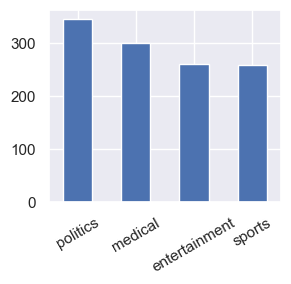

In [143]:
tweet_cat_df = pd.read_csv(DATA_DIR / "nlp/tweet_cat.csv")
vc = tweet_cat_df["type"].value_counts()
print(vc)
tweet_cat_df["type"].value_counts().plot.bar(rot=30, figsize=(3, 2.5));

In [144]:
train_df, test_df = train_test_split(tweet_cat_df, test_size=0.2, random_state=1)

train_dataset = TweetCatDataset(train_df)
test_dataset = TweetCatDataset(
    test_df,
    vocab=train_dataset.vocab,
    encoder=train_dataset.encoder,
)
print(len(train_dataset.vocab), train_dataset.vocab.max_len)
len(train_dataset), len(test_dataset), train_dataset.classes

 86%|████████▌ | 200/233 [00:01<00:00, 115.59it/s]

3367 17


(929, 233, ['entertainment', 'medical', 'politics', 'sports'])

## Построение и обучение модели

In [145]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)


def plot_train_test(
        train_losses: t.List[float],
        train_accuracy: t.List[float],
        test_losses: t.List[float],
        test_accuracy: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_accuracy)
    axes[1].plot(epochs, test_accuracy)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [186]:
class TweetCatRNNClassifier(nn.Module):
    _STATE_T = t.Union[t.Optional[torch.Tensor], t.Optional[t.Tuple[torch.Tensor, torch.Tensor]]]
    rnn_state: _STATE_T

    def __init__(
            self,
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=rnn_hidden_size, num_layers=2, dropout=0.5, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Dropout(0.75),
            nn.Linear(rnn_hidden_size * vector_size, 512),
            nn.ReLU(),
            nn.Dropout(0.75),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes),
        )
        self.reset_rnn_state()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        x, rnn_state = self.rnn(x, self.rnn_state)
        self.keep_rnn_state(rnn_state)

        x = torch.flatten(x, 1)
        return self.classifier(x)

    def reset_rnn_state(self):
        self.rnn_state = None

    def keep_rnn_state(self, state: _STATE_T):
        if isinstance(self.rnn, nn.LSTM):
            self.rnn_state = (state[0].detach(), state[1].detach())
        else:
            self.rnn_state = state.detach()

    def train(self, mode: bool = True):
        self.reset_rnn_state()
        return super().train(mode)

In [187]:
torch.manual_seed(0)

net = TweetCatRNNClassifier(
    num_embeddings=len(train_dataset.vocab),
    embedding_dim=512,
    rnn_hidden_size=128,
    vector_size=train_dataset.vocab.max_len,
    num_classes=len(train_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=get_weights(train_dataset.targets).to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

net

TweetCatRNNClassifier(
  (embedding): Embedding(3367, 512, padding_idx=0)
  (rnn): RNN(512, 128, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Dropout(p=0.75, inplace=False)
    (1): Linear(in_features=2176, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.75, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [188]:
%%time

train_losses, train_accuracy, test_losses, test_accuracy = common_train(
    epochs=10,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 1.408731, accuracy: 0.2780
 Test Error: loss: 1.352074, accuracy: 0.4034

Epoch 2
--------------------------------
Train Error: loss: 1.302325, accuracy: 0.3675
 Test Error: loss: 1.164688, accuracy: 0.4850

Epoch 3
--------------------------------
Train Error: loss: 0.996106, accuracy: 0.5808
 Test Error: loss: 1.184896, accuracy: 0.5279

Epoch 4
--------------------------------
Train Error: loss: 0.675227, accuracy: 0.7209
 Test Error: loss: 1.480454, accuracy: 0.5494

Epoch 5
--------------------------------
Train Error: loss: 0.493832, accuracy: 0.8060
 Test Error: loss: 1.285646, accuracy: 0.5923

Epoch 6
--------------------------------
Train Error: loss: 0.306319, accuracy: 0.8901
 Test Error: loss: 1.683656, accuracy: 0.6266

Epoch 7
--------------------------------
Train Error: loss: 0.302921, accuracy: 0.9009
 Test Error: loss: 1.973750, accuracy: 0.6009

Epoch 8
--------------------------------
Train Error: loss: 0.

## Оценка и выводы

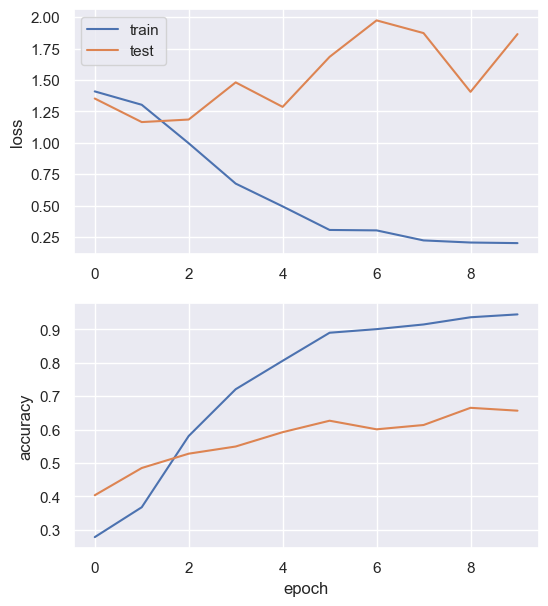

In [189]:
plot_train_test(train_losses, train_accuracy, test_losses, test_accuracy)

In [190]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

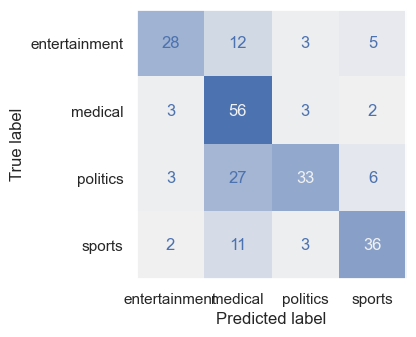

In [191]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [192]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

               precision    recall  f1-score   support

entertainment       0.78      0.58      0.67        48
      medical       0.53      0.88      0.66        64
     politics       0.79      0.48      0.59        69
       sports       0.73      0.69      0.71        52

     accuracy                           0.66       233
    macro avg       0.71      0.66      0.66       233
 weighted avg       0.70      0.66      0.65       233



In [193]:
net.eval()
for i in torch.randperm(len(test_dataset))[:5]:
    x, y = test_dataset[i]
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = net(x.unsqueeze(0))

    pred_proba, pred_label_indices = torch.softmax(pred, 1).topk(min(len(test_dataset.classes), 3), dim=1)
    pred_labels = test_dataset.encoder.inverse_transform(pred_label_indices.squeeze().cpu())
    predicts = ", ".join([f"{label} ({prob:.2f})" for (label, prob) in zip(pred_labels, pred_proba.squeeze())])

    text = test_dataset.texts[i]
    text = text if len(text) < 80 else text[:80] + "..."
    target = test_dataset.encoder.inverse_transform([y.cpu()])[0]

    print(f"Input:   {text}")
    print(f"Target:  {target}")
    print(f"Predict: {predicts}\n")

Input:   hyde contribute campaign follow yovanovitch
Target:  politics
Predict: politics (0.97), entertainment (0.03), sports (0.01)

Input:   seek insight arizona medical cannabis market hop speak business patient advocate...
Target:  medical
Predict: medical (1.00), politics (0.00), sports (0.00)

Input:   girl could make watch tennis say even ruin first major title class
Target:  sports
Predict: sports (0.95), politics (0.04), medical (0.00)

Input:   sander say held hawkish immigration view year ago via
Target:  politics
Predict: politics (0.95), entertainment (0.02), medical (0.02)

Input:   might fuck join tennis club something
Target:  sports
Predict: sports (1.00), politics (0.00), medical (0.00)

